In [2]:
import pm4py
import pandas as pd
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance

## Data pre-processing

Event logs are already filtered and projected in ProM.
- event_log1 (A_events_new.xes) contains only A events with traces ending with A_Pending, A_Cancelled, A_Denied. This log is used for label extraction.
- event_log2 (OA_events.xes) contains A and O events. This log is used for prefix and feature extraction.

After processing, both logs are joined together to form the final set.

Open the event logs

In [3]:
event_log1 = pm4py.read_xes('data/A_events_new.xes')
event_log2 = pm4py.read_xes('data/OA_events.xes')

/Users/xuyou/opt/anaconda3/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31411 [00:00<?, ?it/s]

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

Convert the event logs to dataframes

In [4]:
df1 = pm4py.convert_to_dataframe(event_log1)
df2 = pm4py.convert_to_dataframe(event_log2)

Nomalize the timestamps

In [5]:
df1['time:timestamp'] = pd.to_datetime(df1['time:timestamp'], utc=True)
df2['time:timestamp'] = pd.to_datetime(df2['time:timestamp'], utc=True)
df1['Year'] = df1['time:timestamp'].dt.year
df1['Month'] = df1['time:timestamp'].dt.month

## Add label

Based on the end activies
- If the trace ends with A_Pending "successful"
- If the trace ends with A_Cancelled or A_Denied, the label is "unsuccessful"

In [6]:
success_log = pm4py.filter_end_activities(event_log1, ["A_Pending"])
unsuccess_log = pm4py.filter_end_activities(event_log1, ["A_Cancelled", "A_Denied"])
df_suc = pm4py.convert_to_dataframe(success_log)
df_unsuc = pm4py.convert_to_dataframe(unsuccess_log)

df_suc['label'] = 'successful'
df_unsuc['label'] = 'unsuccessful'

# Concatenate the DataFrames
df1 = pd.concat([df_suc, df_unsuc], ignore_index=True)
df1.head()

/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_34369/2030576452.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_suc['label'] = 'successful'
/var/folders/v1/m2nqhx3d4yv9mjbpndrlsck00000gn/T/ipykernel_34369/2030576452.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unsuc['label'] = 'unsuccessful'


,Action,EventID,EventOrigin,org:resource,concept:name,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:RequestedAmount,case:concept:name,Year,Month,label
0,Created,Application_652823628,Application,User_1,A_Create Application,complete,2016-01-01 09:51:15.304000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
1,statechange,ApplState_1582051990,Application,User_1,A_Submitted,complete,2016-01-01 09:51:15.352000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
2,statechange,ApplState_642383566,Application,User_1,A_Concept,complete,2016-01-01 09:52:36.413000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
3,statechange,ApplState_99568828,Application,User_52,A_Accepted,complete,2016-01-02 11:23:04.299000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful
4,statechange,ApplState_946455804,Application,User_52,A_Complete,complete,2016-01-02 11:30:28.633000+00:00,Existing loan takeover,New credit,20000.0,Application_652823628,2016,1,successful


## Prefix Encoding
We aim to predict the outcome of the application when the first offer is sent. Therefore, all events before the FIRST offer sent (included) are encoded as prefix.

Check all unique events in the traces

In [7]:
unique_events = sorted(df2['concept:name'].unique())
unique_events

['A_Accepted',
 'A_Cancelled',
 'A_Complete',
 'A_Concept',
 'A_Create Application',
 'A_Denied',
 'A_Incomplete',
 'A_Pending',
 'A_Submitted',
 'A_Validating',
 'O_Accepted',
 'O_Cancelled',
 'O_Create Offer',
 'O_Created',
 'O_Refused',
 'O_Returned',
 'O_Sent (mail and online)',
 'O_Sent (online only)']

### Filter the event log to extract prefix

Filter the events so that only the events before the first O_Sent (mail and online) or O_Sent (online only) of each trace are kept

In [8]:
df2 = df2.sort_values(by=['case:concept:name', 'time:timestamp'])

def filter_rows(group):
    idx = group[group['concept:name'].isin(['O_Sent (mail and online)', 'O_Sent (online only)'])].index.min()
    if pd.notna(idx):
        return group.loc[:idx]
    return group

filtered_df2 = df2.groupby('case:concept:name', group_keys=False).apply(filter_rows)

In [9]:
filtered_df2.head()

,Action,EventID,EventOrigin,org:resource,concept:name,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,case:RequestedAmount,case:concept:name,OfferedAmount,CreditScore,Selected,MonthlyCost,Accepted,NumberOfTerms,FirstWithdrawalAmount,OfferID
244258,Created,Application_1000086665,Application,User_1,A_Create Application,complete,2016-08-03 15:57:21.673000+00:00,"Other, see explanation",New credit,5000.0,Application_1000086665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244259,statechange,ApplState_161925113,Application,User_1,A_Submitted,complete,2016-08-03 15:57:21.734000+00:00,"Other, see explanation",New credit,5000.0,Application_1000086665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244260,statechange,ApplState_385184570,Application,User_1,A_Concept,complete,2016-08-03 15:58:28.299000+00:00,"Other, see explanation",New credit,5000.0,Application_1000086665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244261,statechange,ApplState_856156982,Application,User_5,A_Accepted,complete,2016-08-05 13:57:07.419000+00:00,"Other, see explanation",New credit,5000.0,Application_1000086665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
244262,Created,Offer_410892064,Offer,User_5,O_Create Offer,complete,2016-08-05 13:59:57.320000+00:00,"Other, see explanation",New credit,5000.0,Application_1000086665,5000.0,0.0,False,241.28,True,22.0,5000.0,NaN


### Encode the prefix by Aggreagation

All events in the prefix are aggregated into the counting of each event.

In [10]:
result = pd.crosstab(filtered_df2['case:concept:name'], filtered_df2['concept:name']).reindex(unique_events, axis=1, fill_value=0)
result.head()

concept:name,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,O_Accepted,O_Cancelled,O_Create Offer,O_Created,O_Refused,O_Returned,O_Sent (mail and online),O_Sent (online only)
case:concept:name,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000158214,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000311556,1,0,0,1,1,0,0,0,0,0,0,0,1,1,0,0,1,0
Application_1000334415,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0
Application_1000339879,1,0,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0


## Getting trace attribute and merge

Extract and merge all of the case attributes and the label we want to include in the prediction model. They include:
- case:LoanGoal
- case:RequestedAmount
- case:ApplicationType
- CreditScore

Time, month, day are included here just in case of future needs. In the actually training and testing of this model, they are not used and removed.

In [11]:
case_attr_df1 = df1.groupby('case:concept:name').agg({
    'case:LoanGoal': 'first',
    'case:RequestedAmount': 'first',
    'case:ApplicationType': 'first',
    'time:timestamp': 'first',
    'Month': 'first',
    'Year': 'first',
    'label': 'first'
}).reset_index()

case_attr_df2 = df2.groupby('case:concept:name').agg({
    'CreditScore': 'max'
}).reset_index()

case_attr = pd.merge(case_attr_df2, case_attr_df1, on='case:concept:name', how='inner')
case_attr.head()

,case:concept:name,CreditScore,case:LoanGoal,case:RequestedAmount,case:ApplicationType,time:timestamp,Month,Year,label
0,Application_1000086665,0.0,"Other, see explanation",5000.0,New credit,2016-08-03 15:57:21.673000+00:00,8,2016,unsuccessful
1,Application_1000158214,929.0,Home improvement,12500.0,New credit,2016-06-02 10:14:26.844000+00:00,6,2016,successful
2,Application_1000311556,0.0,Car,45000.0,New credit,2016-04-04 15:56:37.675000+00:00,4,2016,unsuccessful
3,Application_1000334415,0.0,"Other, see explanation",5000.0,New credit,2016-09-15 16:39:17.758000+00:00,9,2016,unsuccessful
4,Application_1000339879,798.0,Existing loan takeover,37500.0,New credit,2016-03-17 12:57:10.159000+00:00,3,2016,successful


Merge the trace attributes with the prefix encoding into one final dataframe for model training and testing.

In [12]:
merged_df = pd.merge(result, case_attr, on='case:concept:name', how='inner')
merged_df = merged_df.set_index('case:concept:name')
merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,O_Sent (mail and online),O_Sent (online only),CreditScore,case:LoanGoal,case:RequestedAmount,case:ApplicationType,time:timestamp,Month,Year,label
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,...,1,0,0.0,"Other, see explanation",5000.0,New credit,2016-08-03 15:57:21.673000+00:00,8,2016,unsuccessful
Application_1000158214,1,0,0,1,1,0,0,0,1,0,...,1,0,929.0,Home improvement,12500.0,New credit,2016-06-02 10:14:26.844000+00:00,6,2016,successful
Application_1000311556,1,0,0,1,1,0,0,0,0,0,...,1,0,0.0,Car,45000.0,New credit,2016-04-04 15:56:37.675000+00:00,4,2016,unsuccessful
Application_1000334415,1,0,0,1,1,0,0,0,1,0,...,1,0,0.0,"Other, see explanation",5000.0,New credit,2016-09-15 16:39:17.758000+00:00,9,2016,unsuccessful
Application_1000339879,1,0,0,1,1,0,0,0,1,0,...,1,0,798.0,Existing loan takeover,37500.0,New credit,2016-03-17 12:57:10.159000+00:00,3,2016,successful


## Encode categorical features using one-hot encoding

The two categorical features are LoanGoal and ApplicationType. They are encoded using one-hot encoding.

In [13]:
one_hot_encoded_data = pd.get_dummies(merged_df['case:LoanGoal'], prefix='LoanGoal')
merged_df = merged_df.join(one_hot_encoded_data)
merged_df = merged_df.drop(columns=['case:LoanGoal'])

one_hot_encoded_data = pd.get_dummies(merged_df['case:ApplicationType'], prefix='ApplicationType')
merged_df = merged_df.join(one_hot_encoded_data)
merged_df = merged_df.drop(columns=['case:ApplicationType'])

merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1000086665,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
Application_1000158214,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1000311556,1,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Application_1000334415,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
Application_1000339879,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1


## Train-validate-test set split

Sort the dataset in chronological order.

In [14]:
merged_df['time:timestamp'] = pd.to_datetime(merged_df['time:timestamp'])
merged_df.sort_values(by=['time:timestamp'], inplace=True)
merged_df.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_1691306052,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_428409768,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1746793196,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_828200680,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


Split the data into train and test set. Following time order, the first 70% of the traces are used for training, and the other 30% for testing.

In [15]:
total_rows = len(merged_df)
train_size = int(0.7 * total_rows)
test_size = total_rows - train_size

train = merged_df[:train_size]
test = merged_df[train_size:]

Split the sets.

In [16]:
# Splitting the training set
X_train = train.drop('label', axis=1)
X_train = X_train.drop('time:timestamp', axis=1)
X_train = X_train.drop('Month', axis=1)
X_train = X_train.drop('Year', axis=1)
y_train = train['label']

# Splitting the testing set
X_test = test.drop('label', axis=1)
X_test = X_test.drop('time:timestamp', axis=1)
X_test = X_test.drop('Month', axis=1)
X_test = X_test.drop('Year', axis=1)
y_test = test['label']

Training and testing set overview.

In [17]:
X_train.head()

,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,LoanGoal_Extra spending limit,LoanGoal_Home improvement,LoanGoal_Motorcycle,LoanGoal_Not speficied,"LoanGoal_Other, see explanation",LoanGoal_Remaining debt home,LoanGoal_Tax payments,LoanGoal_Unknown,ApplicationType_Limit raise,ApplicationType_New credit
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_652823628,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_1691306052,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_428409768,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
Application_1746793196,1,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
Application_828200680,1,0,0,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [18]:
y_train.head()

case:concept:name
Application_652823628       successful
Application_1691306052    unsuccessful
Application_428409768       successful
Application_1746793196      successful
Application_828200680     unsuccessful
Name: label, dtype: object

In [19]:
y_test.head()

case:concept:name
Application_961455404       successful
Application_1803529283      successful
Application_1487527238    unsuccessful
Application_1909871555    unsuccessful
Application_829358227     unsuccessful
Name: label, dtype: object

# Create naive predictors
This model serves as our baseline comparision model. For the naivie predictor test set, randomly assign the two lables.

In [20]:
np.random.seed(0)

statuses = ['successful', 'unsuccessful']
y_test_naive = pd.Series(np.random.choice(statuses, size=len(y_test)), index=y_test.index)

print(y_test_naive[:10])

case:concept:name
Application_961455404       successful
Application_1803529283    unsuccessful
Application_1487527238    unsuccessful
Application_1909871555      successful
Application_829358227     unsuccessful
Application_2004102943    unsuccessful
Application_1461070581    unsuccessful
Application_71554822      unsuccessful
Application_433848400     unsuccessful
Application_148404117     unsuccessful
dtype: object


## Prediction

### Naive Predictor Performance

Accuracy: 0.4939516129032258
Precision: 0.4879142300194932
Recall: 0.5388589881593111
F1 Score: 0.5121227621483376


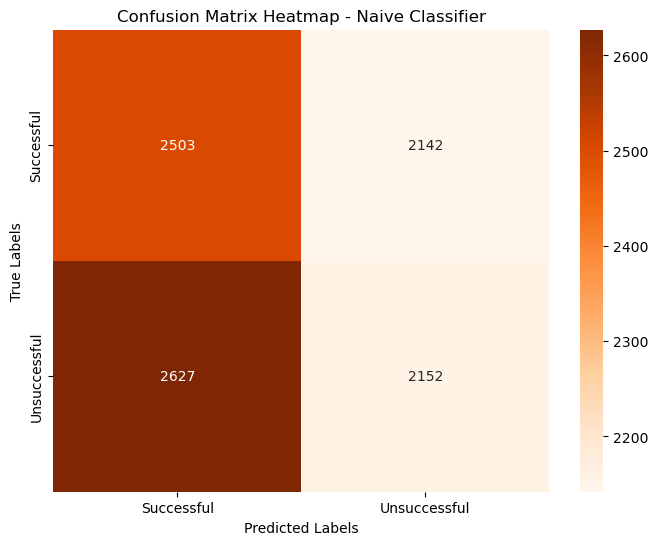

In [21]:
accuracy = accuracy_score(y_test_naive, y_test)
precision = precision_score(y_test_naive, y_test, pos_label='successful')
recall = recall_score(y_test_naive, y_test, pos_label='successful')
f1 = f1_score(y_test_naive, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_test_naive, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap - Naive Classifier')

# Display the heatmap
plt.show()

### Decision Tree

Model training

In [22]:
clf = tree.DecisionTreeClassifier()
y_pred = clf.fit(X_train, y_train).predict(X_test)

Evaluation

Accuracy: 0.9700764006791172
Precision: 0.9855750487329434
Recall: 0.9604863221884499
F1 Score: 0.9728689628631902


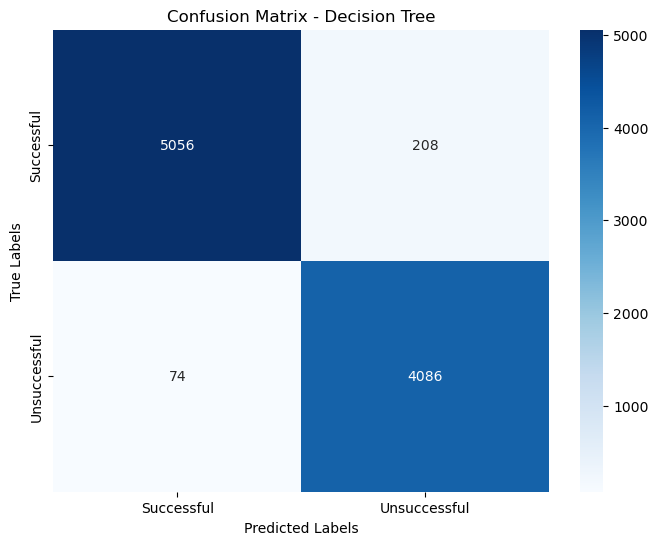

In [23]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, pos_label='successful')
recall = recall_score(y_pred, y_test, pos_label='successful')
f1 = f1_score(y_pred, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_pred, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Decision Tree')

# Display the heatmap
plt.show()

Feature importance

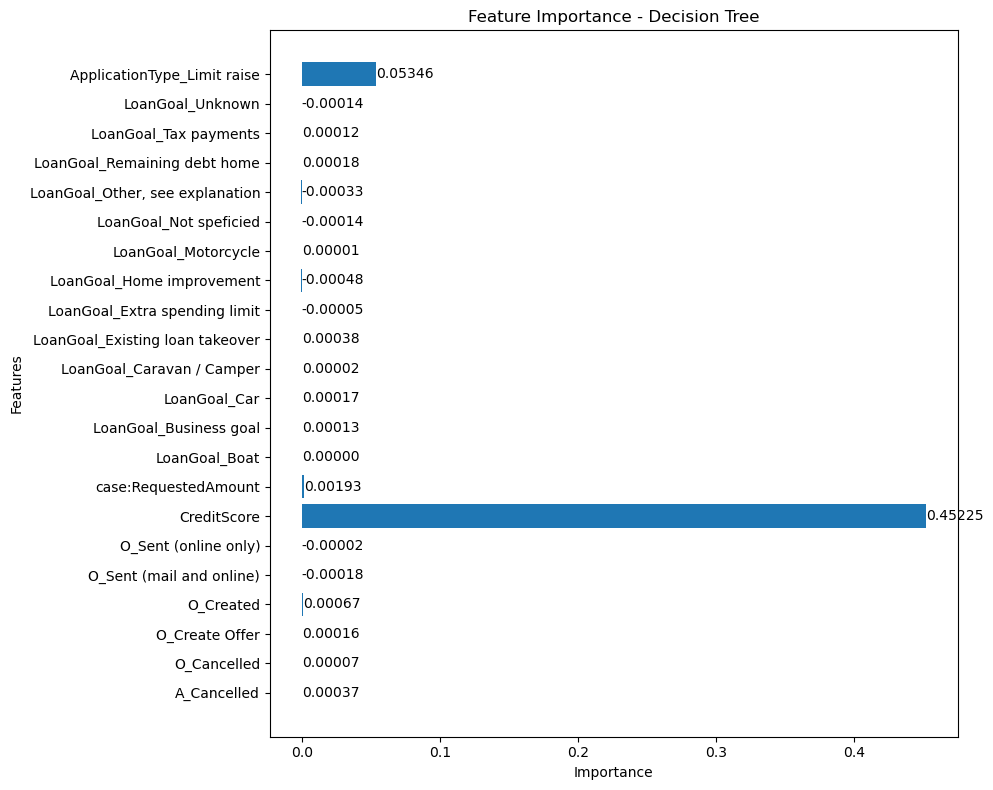

In [24]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Summarize feature importance
feature_importance = result.importances_mean

# Get feature names
feature_names = X_test.columns

# Filter out features with zero importance
non_zero_importance = feature_importance != 0
filtered_feature_names = feature_names[non_zero_importance]
filtered_feature_importance = feature_importance[non_zero_importance]

# Plotting feature importance with swapped axes, excluding zero-importance features
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
bars = plt.barh(filtered_feature_names, filtered_feature_importance)  # 'barh' creates horizontal bar plot

# Add the numerical values on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.5f}', 
             va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Decision Tree')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### SVM

Model training

In [25]:
clf = svm.SVC()
y_pred = clf.fit(X_train, y_train).predict(X_test)

Evaluation

Accuracy: 0.9375
Precision: 0.8855750487329435
Recall: 0.9995599559955995
F1 Score: 0.9391214470284238


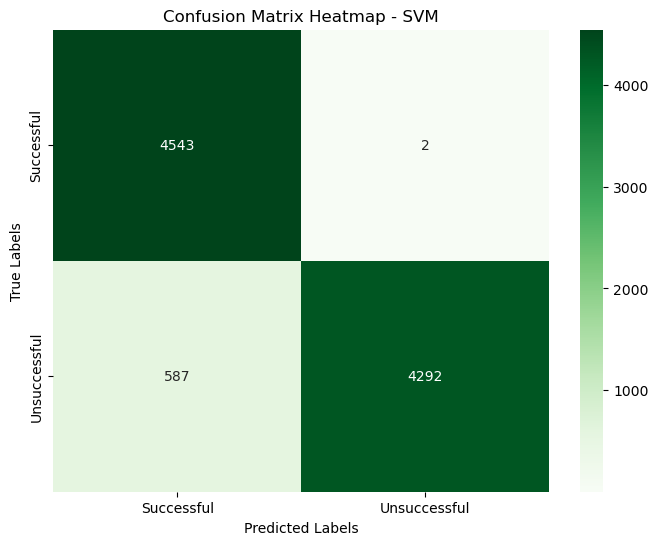

In [26]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, pos_label='successful')
recall = recall_score(y_pred, y_test, pos_label='successful')
f1 = f1_score(y_pred, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_pred, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap - SVM')

# Display the heatmap
plt.show()

Feature importance

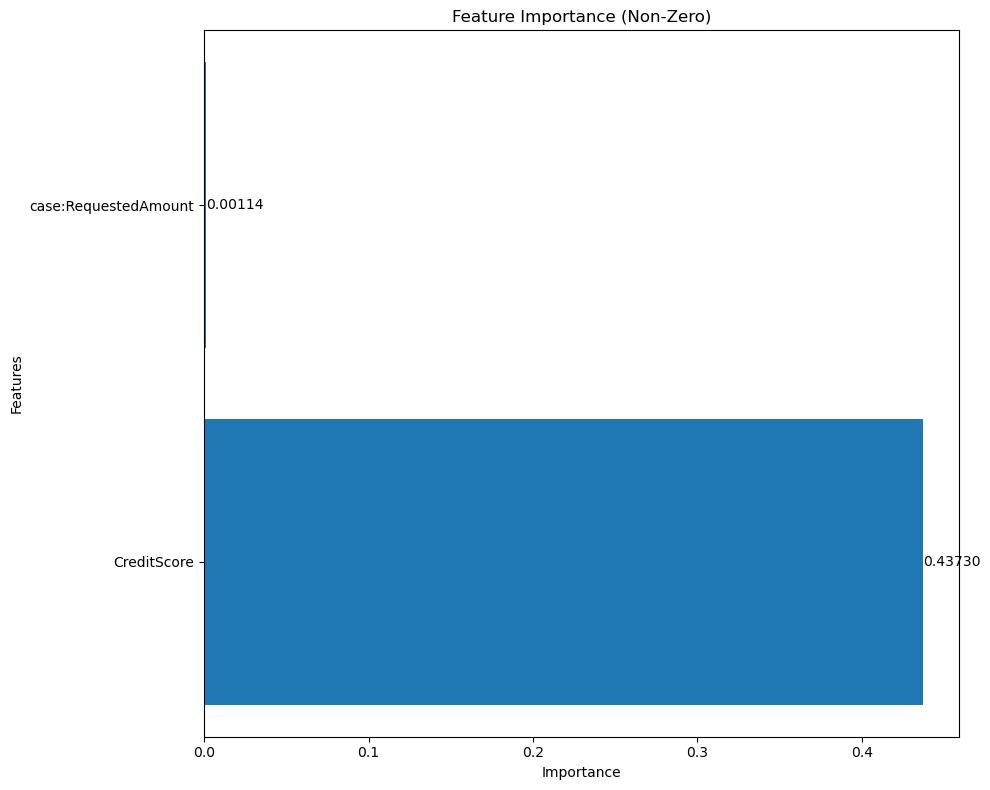

In [32]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Summarize feature importance
feature_importance = result.importances_mean

# Get feature names
feature_names = X_test.columns

# Filter out features with zero importance
non_zero_importance = feature_importance != 0
filtered_feature_names = feature_names[non_zero_importance]
filtered_feature_importance = feature_importance[non_zero_importance]

# Plotting feature importance with swapped axes, excluding zero-importance features
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
bars = plt.barh(filtered_feature_names, filtered_feature_importance)  # 'barh' creates horizontal bar plot

# Add the numerical values on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.5f}', 
             va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - SVM')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### Gradient Boosting

Model training

In [27]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
y_pred = clf.fit(X_train, y_train).predict(X_test)

Evaluation

Accuracy: 0.9750636672325976
Precision: 0.9990253411306043
Recall: 0.9570494864612512
F1 Score: 0.9775870290891749


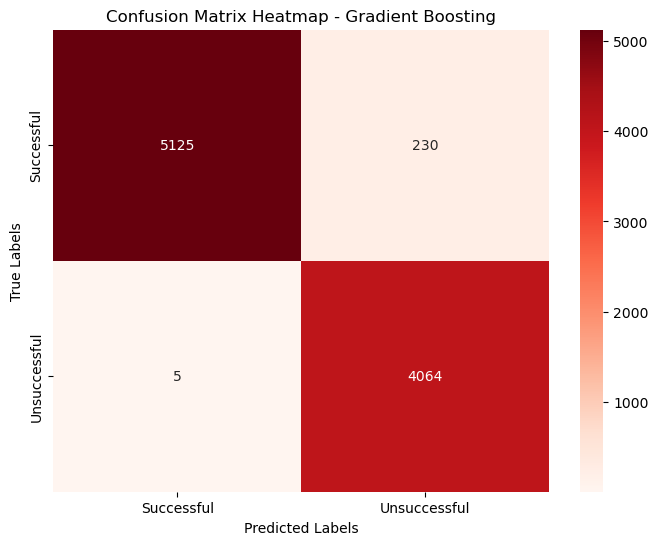

In [28]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, pos_label='successful')
recall = recall_score(y_pred, y_test, pos_label='successful')
f1 = f1_score(y_pred, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_pred, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap - Gradient Boosting')

# Display the heatmap
plt.show()

Feature importance

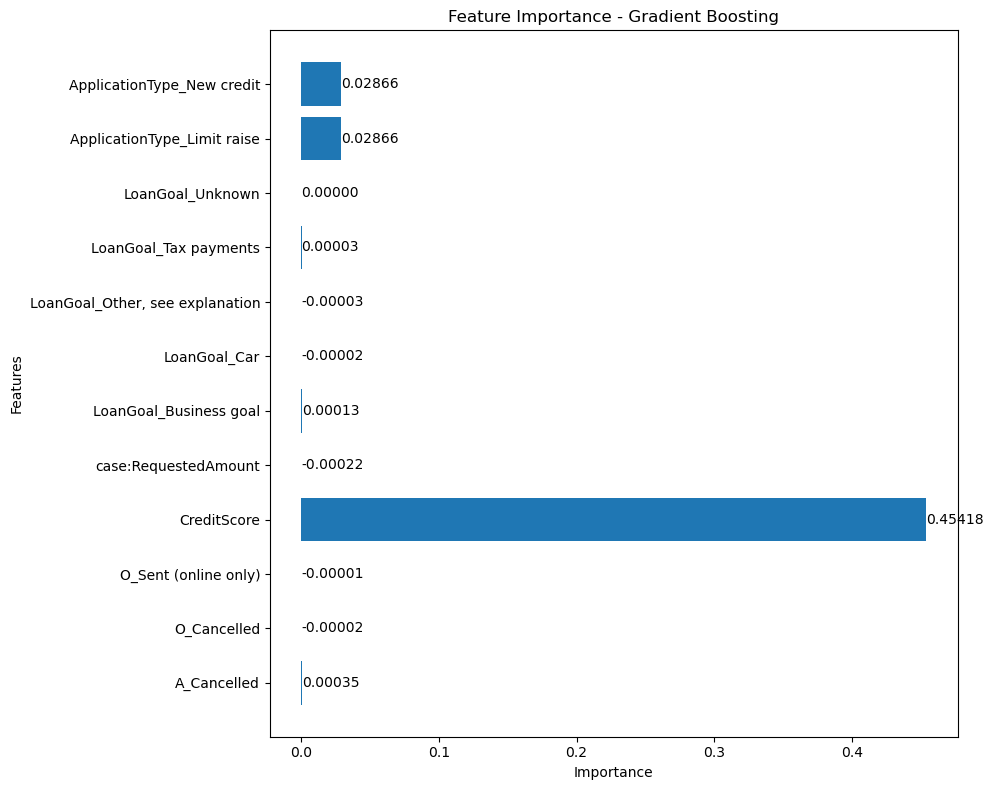

In [29]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Summarize feature importance
feature_importance = result.importances_mean

# Get feature names
feature_names = X_test.columns

# Filter out features with zero importance
non_zero_importance = feature_importance != 0
filtered_feature_names = feature_names[non_zero_importance]
filtered_feature_importance = feature_importance[non_zero_importance]

# Plotting feature importance with swapped axes, excluding zero-importance features
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
bars = plt.barh(filtered_feature_names, filtered_feature_importance)  # 'barh' creates horizontal bar plot

# Add the numerical values on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.5f}', 
             va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Gradient Boosting')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

### Logistic Regression

Model training

In [30]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.fit(X_train, y_train).predict(X_test)

Evaluation

Accuracy: 0.974320882852292
Precision: 0.9974658869395712
Recall: 0.9571642349420127
F1 Score: 0.9768995799923635


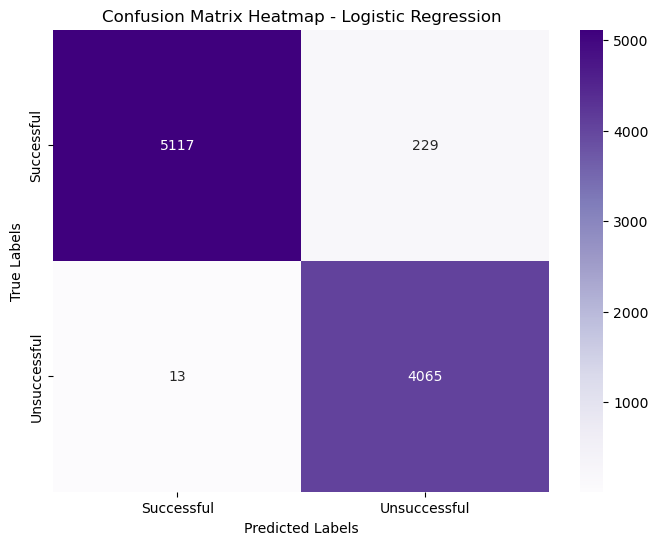

In [31]:
accuracy = accuracy_score(y_pred, y_test)
precision = precision_score(y_pred, y_test, pos_label='successful')
recall = recall_score(y_pred, y_test, pos_label='successful')
f1 = f1_score(y_pred, y_test, pos_label='successful')
conf_matrix = confusion_matrix(y_pred, y_test, labels=['successful', 'unsuccessful'])

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

labels = np.array([['True Successful', 'False Unsuccessful'],
                   ['False Successful', 'True Unsuccessful']])

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=['Successful', 'Unsuccessful'], yticklabels=['Successful', 'Unsuccessful'])

# Add labels and a title
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap - Logistic Regression')

# Display the heatmap
plt.show()

Feature importance

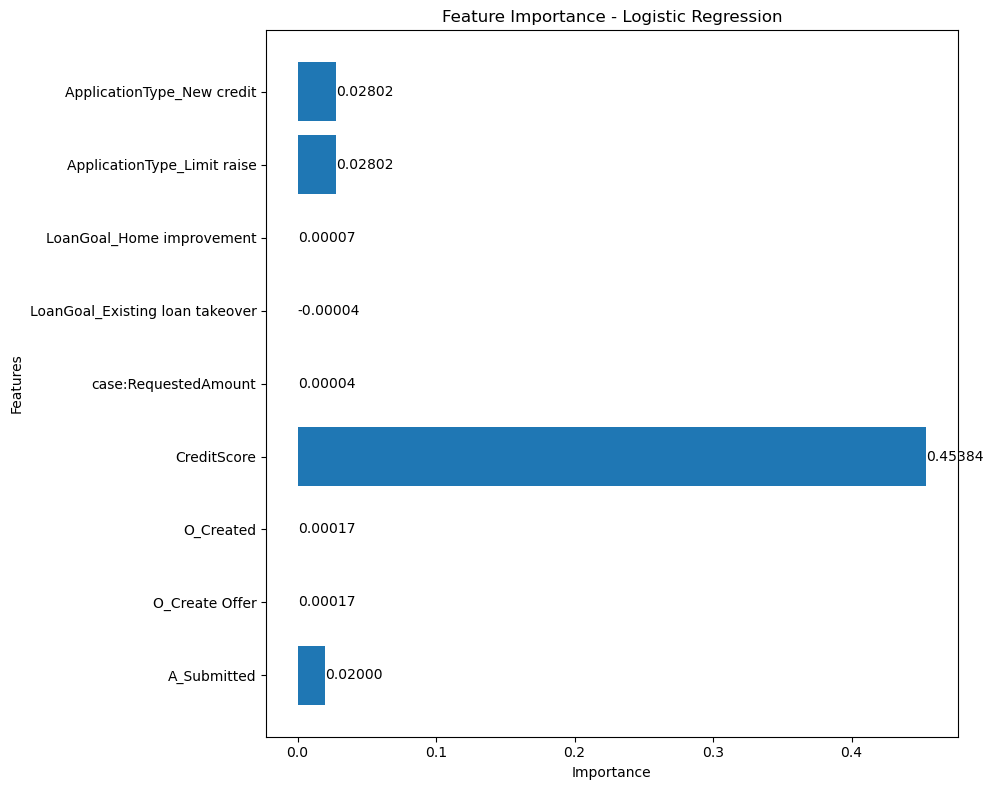

In [32]:
result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42)

# Summarize feature importance
feature_importance = result.importances_mean

# Get feature names
feature_names = X_test.columns

# Filter out features with zero importance
non_zero_importance = feature_importance != 0
filtered_feature_names = feature_names[non_zero_importance]
filtered_feature_importance = feature_importance[non_zero_importance]

# Plotting feature importance with swapped axes, excluding zero-importance features
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
bars = plt.barh(filtered_feature_names, filtered_feature_importance)  # 'barh' creates horizontal bar plot

# Add the numerical values on top of each bar
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, 
             f'{bar.get_width():.5f}', 
             va='center', ha='left')

plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Logistic Regression')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()